<a href="https://colab.research.google.com/github/MarchTerX/Data-Sci-Mini-project/blob/Master/Miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import library**

In [233]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import random
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


เอาชื่อ pokemon เข้ามา จาก directory ของ folder PokemonData

In [141]:
directory = "/content/drive/My Drive/344-331/PokemonData"
labels = os.listdir(directory)
labels

['Pikachu', 'Mewtwo', 'Mew', 'Eevee', 'Ditto', 'Charizard']

นำรูป Pokemon เข้ามา

In [142]:
def load_and_preprocess_data(directory):
    dataset = []
    labels = os.listdir(directory)
    count = 0
    for label in labels:
        folder = os.path.join(directory, label)
        for image in os.listdir(folder):
            try:
                img = load_img(os.path.join(folder, image), target_size=(224, 224))
                img = img_to_array(img)
                img = preprocess_input(img)
                dataset.append((img, count))
            except Exception as e:
                print(f"Error loading image '{image}': {str(e)}")

        print(f'\rCompleted: {label}', end='')
        count += 1

    random.shuffle(dataset)
    X, y = zip(*dataset)

    return np.array(X), np.array(y), labels

In [143]:
images, labels, label_names = load_and_preprocess_data(directory)

Completed: Charizard

In [144]:
np.unique(label_names)

array(['Charizard', 'Ditto', 'Eevee', 'Mew', 'Mewtwo', 'Pikachu'],
      dtype='<U9')

**แสดงรูป ตัวอย่าง Pokemon 10 รูป**

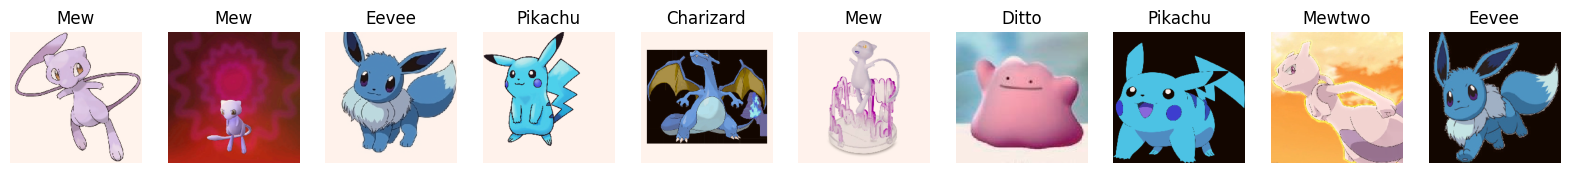

In [145]:
num_images = 10

fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

for i in range(num_images):
    image = images[i]
    image = image - np.min(image)
    image = image / np.max(image)

    axes[i].imshow(image)
    axes[i].set_title(label_names[labels[i]])
    axes[i].axis('off')

plt.show()

**แยกข้อมูลออกเป็น ชุด test และ train**

In [146]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=1)

**ทำ Feature extraction ด้วย vgg16**

In [147]:
# Load pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [148]:
# Extract features
X_train_features = vgg_model.predict(X_train)
X_test_features = vgg_model.predict(X_test)

3/3 [==============================] - 44s 12s/step


In [149]:
# Flatten extracted features
X_train_flatten = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_flatten = X_test_features.reshape(X_test_features.shape[0], -1)

**SAVE ข้อมูลที่ได้ทำการ Feature extraction**

In [270]:
np.savetxt('X_train_features.csv', X_train_flatten, delimiter=',')
np.savetxt('X_test_features.csv', X_test_flatten, delimiter=',')

# **MLP MODEL**

กำหนด parameter เพื่อการทำ cross validation

In [200]:
param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (300,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01]
}

In [201]:
grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=10)

train model โดยใช้ parameter ข้างต้น

In [202]:
grid_search.fit(X_train_flatten, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (200,), 'solver': 'adam'}


In [203]:
best_model = grid_search.best_estimator_
best_cv_score = grid_search.best_score_
print("Best Cross Validation Score:", best_cv_score)

Best Cross Validation Score: 0.9571428571428571


เลือก parameter ที่ดีที่สุดมาใช้งาน

In [204]:
mlp_classifier = best_model

ทำการทำนาย pokemon

In [205]:
y_pred = mlp_classifier.predict(X_test_flatten)

แสดงรูปภาพ pokemon พร้อมกับ ผลที่ทำนาย และ ชื่อที่ถูกต้องของ pokemon

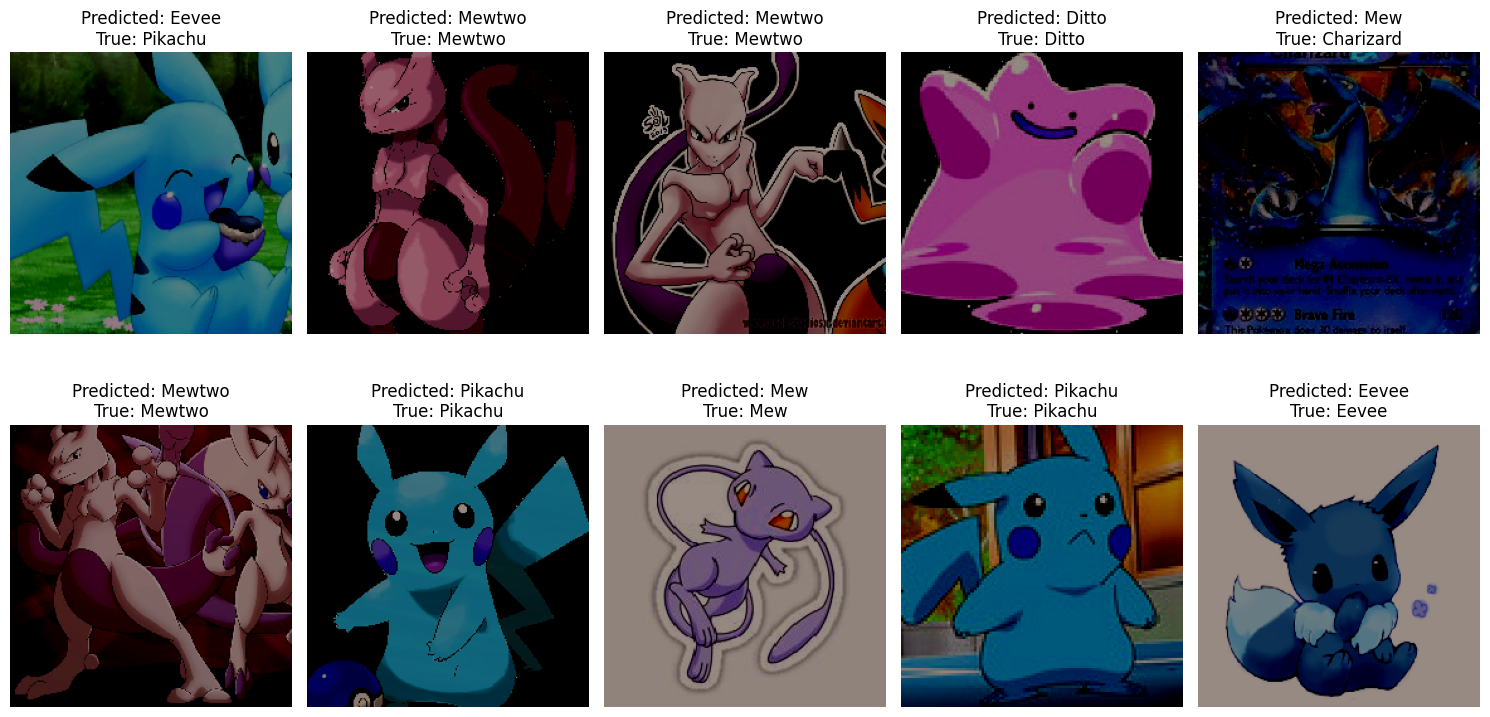

In [206]:
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # แปลงค่าข้อมูลภาพให้อยู่ในช่วง [0, 1]
    image = X_test[i].reshape(224, 224, 3) / 255.0

    # แสดงภาพ
    plt.imshow(image)
    plt.axis('off')

    # ป้ายชื่อที่ทำนายและป้ายชื่อจริง
    predicted_label_index = y_pred[i]
    predicted_label = label_names[predicted_label_index]
    true_label = label_names[y_test[i]]
    plt.title(f'Predicted: {predicted_label}\nTrue: {true_label}')

plt.tight_layout()
plt.show()

**Evaluation**

In [207]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9285714285714286


In [208]:
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.9282227905655016


In [210]:
cv_scores = cross_val_score(mlp_classifier, X_train_flatten, y_train, cv=5)

In [211]:
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.83333333 0.9047619  0.88095238 0.95238095 0.92857143]
Mean cross-validation score: 0.9


**confusion** **matrix**

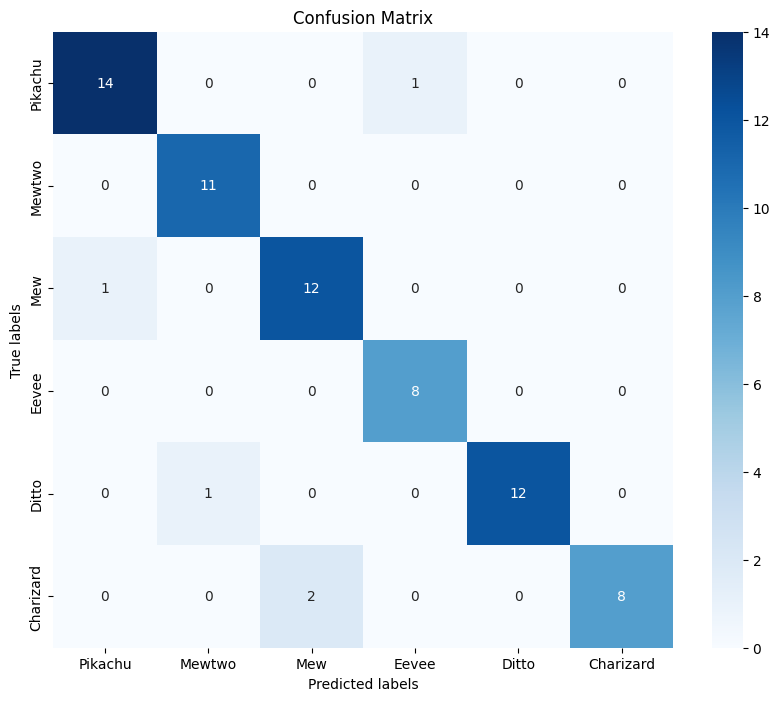

In [212]:
# สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix ในรูปแบบ Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# KNN Model

In [234]:
knn_classifier = KNeighborsClassifier()

กำหนด parameter เพื่อการทำ cross validation

In [236]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [237]:
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5)

train model โดยใช้ parameter ข้างต้น

In [238]:
grid_search.fit(X_train_flatten, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']})

In [239]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross Validation Score:", grid_search.best_score_)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best Cross Validation Score: 0.661904761904762


เลือก parameter ที่ดีที่สุดมาใช้งาน

In [240]:
knn_classifier = grid_search.best_estimator_

ทำการทำนาย pokemon

In [241]:
y_pred = knn_classifier.predict(X_test_flatten)

แสดงรูปภาพ pokemon พร้อมกับ ผลที่ทำนาย และ ชื่อที่ถูกต้องของ pokemon

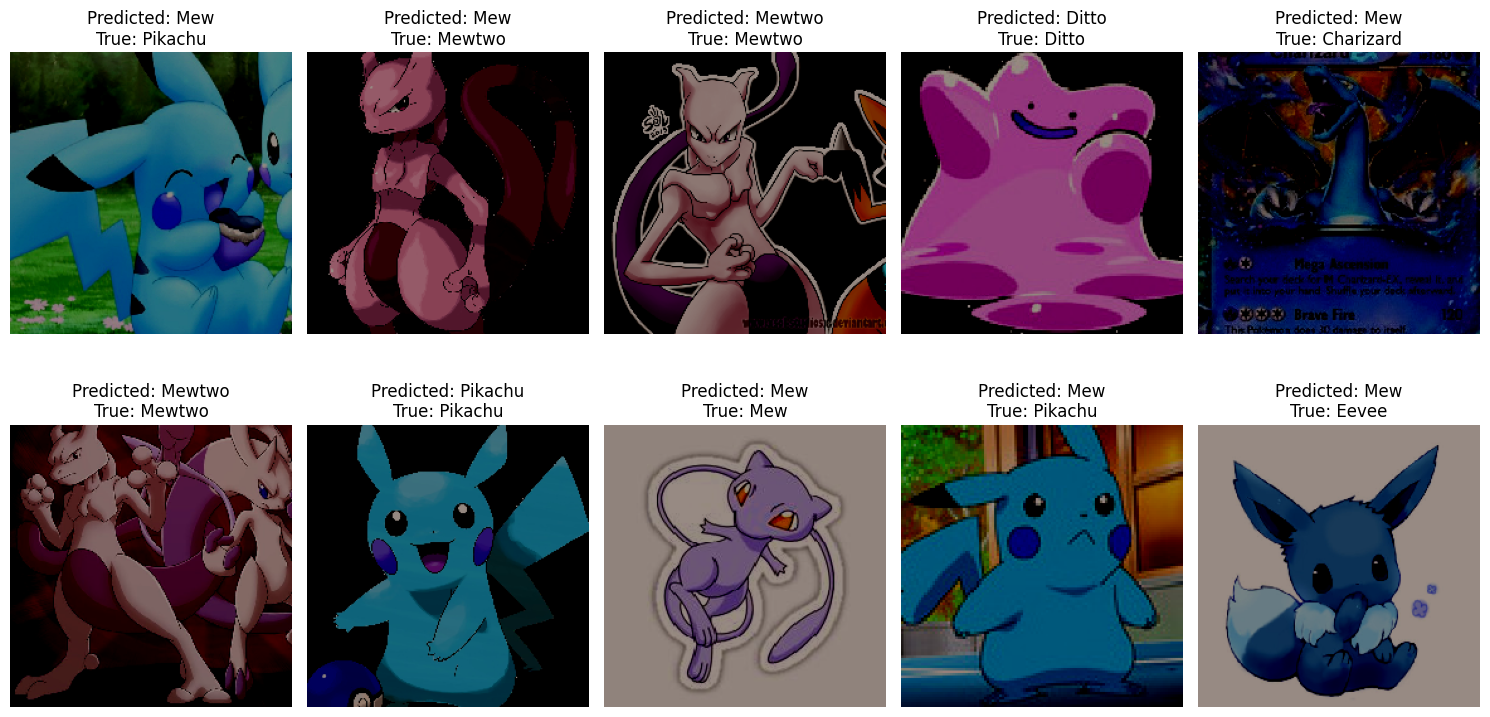

In [242]:
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # แปลงค่าข้อมูลภาพให้อยู่ในช่วง [0, 1]
    image = X_test[i].reshape(224, 224, 3) / 255.0

    # แสดงภาพ
    plt.imshow(image)
    plt.axis('off')

    # ป้ายชื่อที่ทำนายและป้ายชื่อจริง
    predicted_label_index = y_pred[i]
    predicted_label = label_names[predicted_label_index]
    true_label = label_names[y_test[i]]
    plt.title(f'Predicted: {predicted_label}\nTrue: {true_label}')

plt.tight_layout()
plt.show()

**Evaluation**

In [243]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6571428571428571


In [244]:
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.630356422636813


In [245]:
cv_scores = cross_val_score(mlp_classifier, X_train_flatten, y_train, cv=5)

In [246]:
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.78571429 0.95238095 0.92857143 1.         0.95238095]
Mean cross-validation score: 0.9238095238095239


**confusion** **matrix**

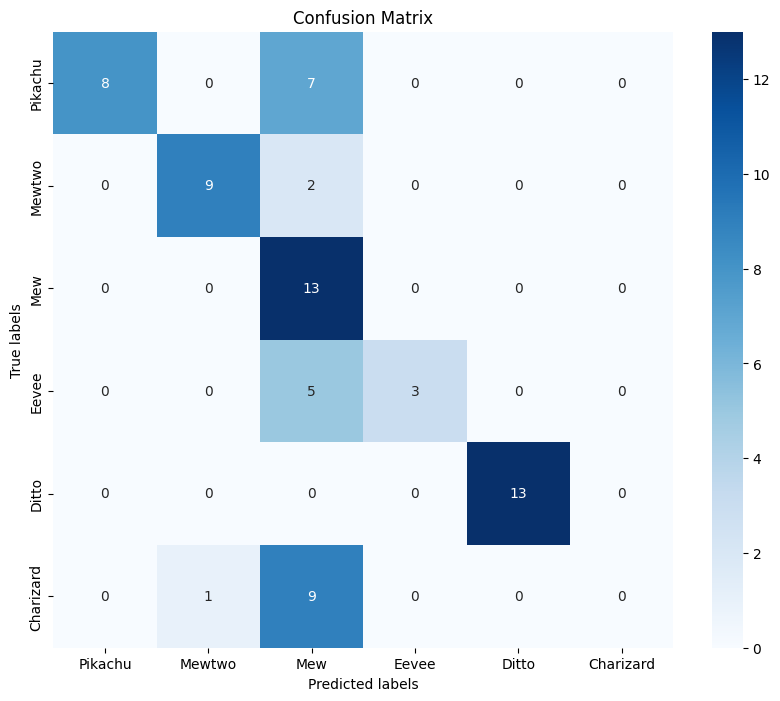

In [247]:
# สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix ในรูปแบบ Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# ประสิทธิภาพของทั้ง 2 โมเดล

**MLP MODEL**


   จากการทำ Evaluation จะพบว่า เมื่อใช้ mlp model และใช้การ cross validation เพื่อหา parameter ที่ดีที่สุด ผลลัพธ์จะได้ว่า mlp model นั้น ได้ค่า Accuracy ที่สูงมากที่ 0.9285714285714286 และได้ค่า F1 Score ที่สูงมากเช่นกันซึ่งมีค่าใกล้เคียงกับค่า Accuracy ซึ่งจะอยู่ที่ 0.9282227905655016 ซึ่งเมื่อค่าความถูกต้องออกมาดังนี้แปลว่า การทำนาย pokemon นั้นมีความถูกต้องเป็นอย่างมาก โดยสามารถดูได้จาก confusion matrix

**KNN MODEL**

  และจากการใช้ knn model ในการแยก pokemon จากรูปภาพ และมีการใช้ cross validation เพื่อหา parameter ที่ดีที่สุด โดยได้ผลลัพธ์จากการทำ Evaluation จะพบว่าค่า Accuracy ที่ค่อนข้างต่ำ จะอยู่ที่ 0.6571428571428571 และ ค่า F1 Score จะได้ 0.630356422636813 ซึ่งแสดงให้เห็นว่าประสิทธิภาพของ knn model นั้นน้อยกว่า mlp ในการทำการแยก pokemon อาจเป็นเพราะโมเดล knn มีความซับซ้อนน้อยกว่าและไม่สามารถจับจังหวะได้ดีกับลักษณะของข้อมูลที่ซับซ้อนมากขึ้น ทำให้มีประสิทธิภาพในการจำแนกประเภทที่ต่ำ

# บันทึก Model

ทำการ บันทึก model ที่ดีที่สุด ซึ่งก็คือ MLP

In [253]:
import pickle

with open('mlp_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

โหลด model มาใช้งาน

In [254]:
with open('mlp_model.pkl', 'rb') as f:
    mlp_model = pickle.load(f)

นำตัวอย่างเข้ามา 1 ตัวอย่าง

In [263]:
import cv2

image_path = '/content/drive/My Drive/344-331/Pikachu-test.jpg'
image = cv2.imread(image_path)

แสดงรูปภาพที่นำเข้ามา

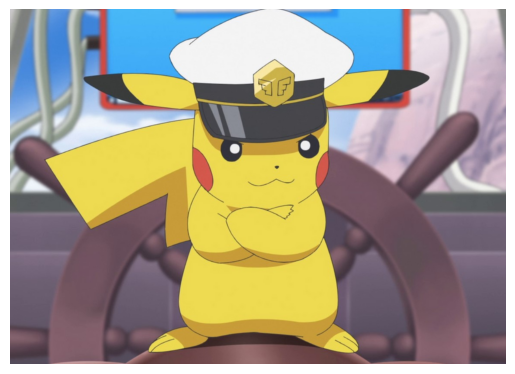

In [269]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

สร้าง function ในการ feature extraction

In [264]:
def extract_features(image):
    model = VGG16(weights='imagenet', include_top=False)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    features = model.predict(preprocess_input(image))
    features = features.flatten()

    return features

ทำ feature extraction

In [265]:
features = extract_features(image)

1/1 [==============================] - 1s 1s/step


ทำนายผล

In [268]:
predicted_label_index = mlp_model.predict(np.array([features]))[0]
predicted_label = label_names[predicted_label_index]

print("Predicted Pokemon:", predicted_label)

Predicted Pokemon: Pikachu
